# Setup Imports

In [9]:
# Setup
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from userdefinedmodels import *

# Setup Location and Weather

In [10]:
# evaluate hood river, oregon and key west, florida

# latitude, longitude, name, altitude, timezone
hood_river = (45.71417626139969, -121.5154782530592, 'Hood River', 27, 'Etc/GMT+8')
latitude, longitude, name, altitude, timezone = hood_river

location = Location(
    latitude,
    longitude,
    name=name,
    altitude=altitude,
    tz=timezone,
    )

# psm3_file_name
psm3_file_name = 'hood_river_22_psm3_weather.csv'

# create dataframe from csv
weather = pd.read_csv(psm3_file_name, index_col=0, parse_dates=True)



## Sunrise Data

# Setup Systems

## Module Parameters

In [11]:
# Get the module parameters from the CEC database
MODULE_24 = pvlib.pvsystem.retrieve_sam('CECMod')['JA_Solar_JAM5_L__72_200_SI']

# Create a dictionary of the parameters to represent the 12V Rich Solar module
# Scale the paremters that can be easily scaled
rich_solar_12V_params = {
    'Name' : 'Rich Solar 12V',
    'Technology': MODULE_24['Technology'],
    'Bifacial' : MODULE_24['Bifacial'],
    'STC' : MODULE_24['STC'],
    'PTC' : MODULE_24['PTC'],
    'A_c' : MODULE_24['A_c']*2,
    'Length' : MODULE_24['Length'],
    'Width' : MODULE_24['Width'],
    'N_s' : MODULE_24['N_s']/2,
    'I_sc_ref' : MODULE_24['I_sc_ref']*2,
    'V_oc_ref' : MODULE_24['V_oc_ref']/2,
    'I_mp_ref' : MODULE_24['I_mp_ref']*2,
    'V_mp_ref' : MODULE_24['V_mp_ref']/2,
    'alpha_sc' : MODULE_24['alpha_sc']*2,
    'beta_oc' : MODULE_24['beta_oc']/2,
    'gamma_r' : MODULE_24['gamma_r'],
    'T_NOCT' : MODULE_24['T_NOCT'],
}

# Caculate the remaining parameters for the 12V module
I_L_ref, I_o_ref, R_s, R_sh_ref, a_ref, Adjust = pvlib.ivtools.sdm.fit_cec_sam(
                                                                         celltype='monoSi',
                                                                         v_mp=rich_solar_12V_params['V_mp_ref'],
                                                                         i_mp=rich_solar_12V_params['I_mp_ref'],
                                                                         v_oc=rich_solar_12V_params['V_oc_ref'],
                                                                         i_sc=rich_solar_12V_params['I_sc_ref'],
                                                                         alpha_sc=rich_solar_12V_params['alpha_sc'],
                                                                         beta_voc=rich_solar_12V_params['beta_oc'],
                                                                         gamma_pmp=rich_solar_12V_params['gamma_r'],
                                                                         cells_in_series=rich_solar_12V_params['N_s']
                                                                         )

# Add the calculated parameters to the dictionary representing the 12V Rich Solar module
rich_solar_12V_params['a_ref'] = a_ref
rich_solar_12V_params['I_L_ref'] = I_L_ref
rich_solar_12V_params['I_o_ref'] = I_o_ref
rich_solar_12V_params['R_s'] = R_s
rich_solar_12V_params['R_sh_ref'] = R_sh_ref
rich_solar_12V_params['Adjust'] = Adjust

## Temperature Parameters

In [12]:
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

## Inverter (MPPT) Parameters  

In [13]:
# We'll start with no wire losses and perfect MPPT efficiency
r_batt_wire = getWireResistance('8AWG', 5)
r_pv_wire = getWireResistance('8AWG', 10)


mppt_parameters = {
    'v_batt': 13.9,
    'v_start_delta': 5.0,
    'v_continue_delta': 1.0,
    'r_batt_wire': r_batt_wire,
    'r_pv_wire': r_pv_wire,
    'mppt_eff': 1.0
}

In [14]:

mount = FixedMount(
    surface_tilt=0,
    surface_azimuth=180,
    )
arraySeries = Array(
    mount=mount,
    module_parameters=rich_solar_12V_params,
    temperature_model_parameters=temperature_model_parameters,
    strings=1,
    modules_per_string=2,
    )

arrayParallel = Array(
    mount=mount,
    module_parameters=rich_solar_12V_params,
    temperature_model_parameters=temperature_model_parameters,
    strings=2,
    modules_per_string=1,
    )


systemSeries = PVSystem(arrays=[arraySeries], 
                  inverter_parameters=mppt_parameters)

systemParallel = PVSystem(arrays=[arrayParallel],
                    inverter_parameters=mppt_parameters)

mcSeries = ModelChain(systemSeries, 
                location, 
                aoi_model="physical", 
                spectral_model="no_loss", 
                dc_model="cec",
                ac_model=mppt,
                dc_ohmic_model=pv_wire_loss
                )

mcParallel = ModelChain(systemParallel, 
                location, 
                aoi_model="physical", 
                spectral_model="no_loss", 
                dc_model="cec",
                ac_model=mppt,
                dc_ohmic_model=pv_wire_loss
                )

mcSeries.run_model(weather)
mcParallel.run_model(weather)


ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: functools.partial(<function mppt at 0xffff375f0ae0>, ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: ...
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses)
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

2022-01-01  delta [W-hr]:  0.7743331979586401  max cell temp [C]: 12.11363543944493
2022-01-02  delta [W-hr]:  0.3913588762484892  max cell temp [C]: 16.637583123575254
2022-01-03  delta [W-hr]:  0.021069421675434796  max cell temp [C]: 8.718132770703834
2022-01-04  delta [W-hr]:  0.04945397168265231  max cell temp [C]: 8.982419350146358
2022-01-05  delta [W-hr]:  0.03676266124810468  max cell temp [C]: 8.474957351090724
2022-01-06  delta [W-hr]:  0.09529918926460823  max cell temp [C]: 12.975679661456587
2022-01-07  delta [W-hr]:  0.12077562659223418  max cell temp [C]: 13.959224454632178
2022-01-08  delta [W-hr]:  0.6720340663854358  max cell temp [C]: 19.144358866098507
2022-01-09  delta [W-hr]:  0.9774233927228124  max cell temp [C]: 20.217353854380978
2022-01-10  delta [W-hr]:  0.5336565188993632  max cell temp [C]: 18.952343769304342
2022-01-11  delta [W-hr]:  0.38489060522226737  max cell temp [C]: 22.52431098389921
2022-01-12  delta [W-hr]:  0.7063925550027079  max cell temp [C

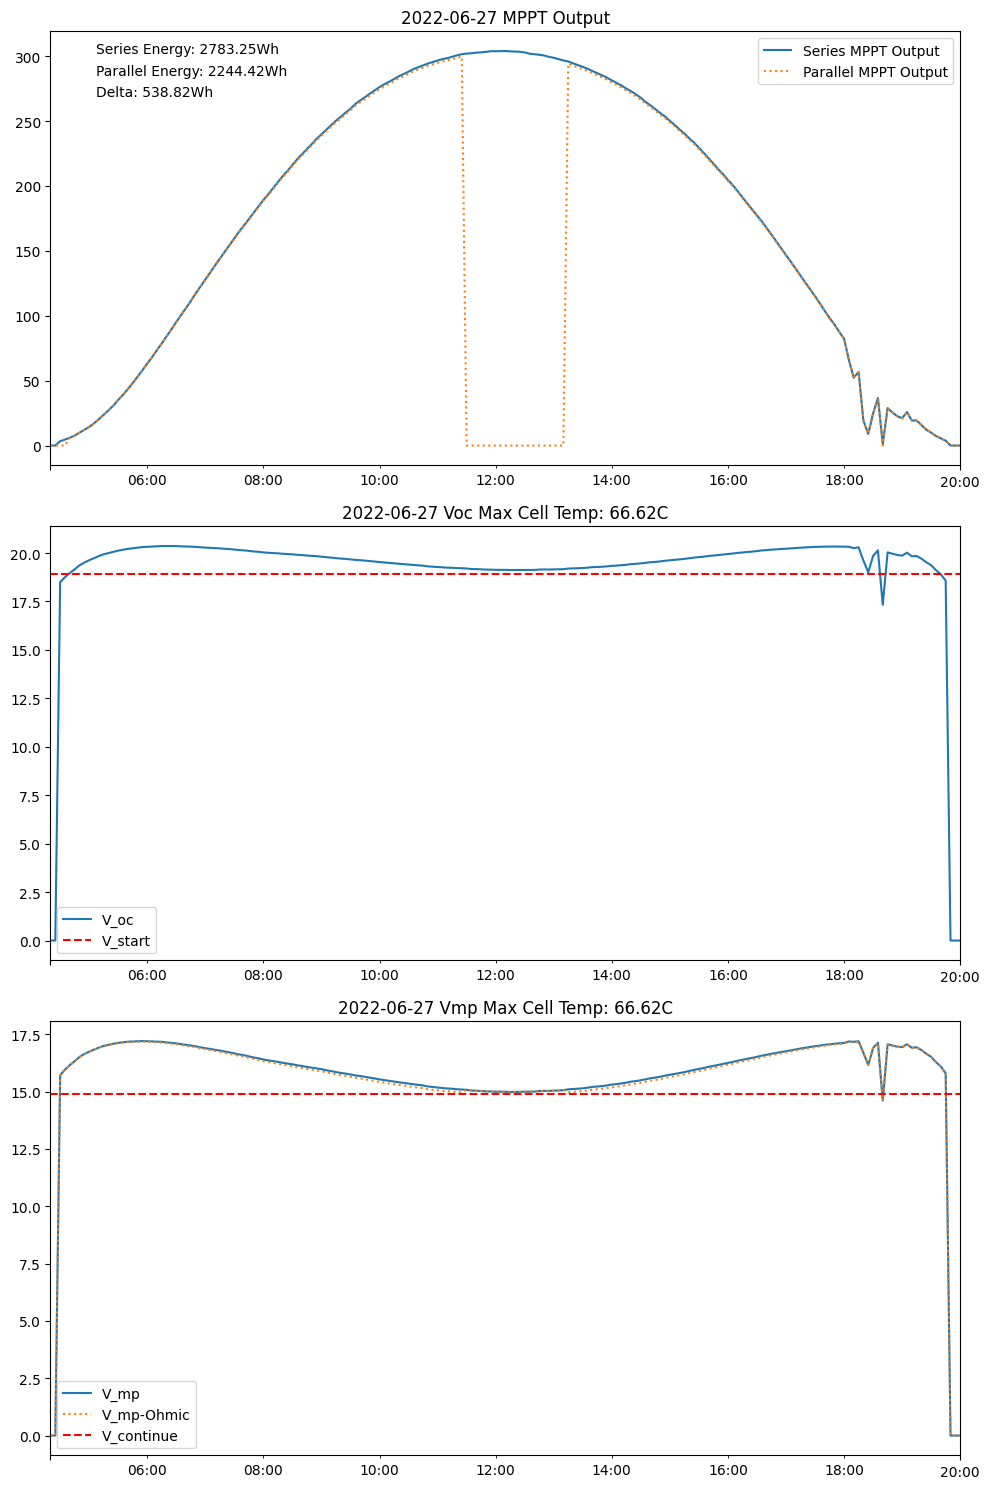

2022-06-28  delta [W-hr]:  12.724915778264403  max cell temp [C]: 54.00856953426993
2022-06-29  delta [W-hr]:  13.34701209151035  max cell temp [C]: 56.301920448974414
2022-06-30  delta [W-hr]:  12.814118768615572  max cell temp [C]: 59.77461509788407
2022-07-01  delta [W-hr]:  13.310068955240695  max cell temp [C]: 58.36729162065093
2022-07-02  delta [W-hr]:  10.549499430527703  max cell temp [C]: 55.01379092245774
2022-07-03  delta [W-hr]:  12.987390470414084  max cell temp [C]: 52.36407491279633
2022-07-04  delta [W-hr]:  12.101014028597092  max cell temp [C]: 55.01437266990591
2022-07-05  delta [W-hr]:  6.0586264926773765  max cell temp [C]: 56.956280152070406
2022-07-06  delta [W-hr]:  4.807629851458387  max cell temp [C]: 53.07894939679577
2022-07-07  delta [W-hr]:  9.690973184240192  max cell temp [C]: 53.7484359647619
2022-07-08  delta [W-hr]:  10.494936641179265  max cell temp [C]: 56.907805915760875
2022-07-09  delta [W-hr]:  10.274477914226736  max cell temp [C]: 56.49064805

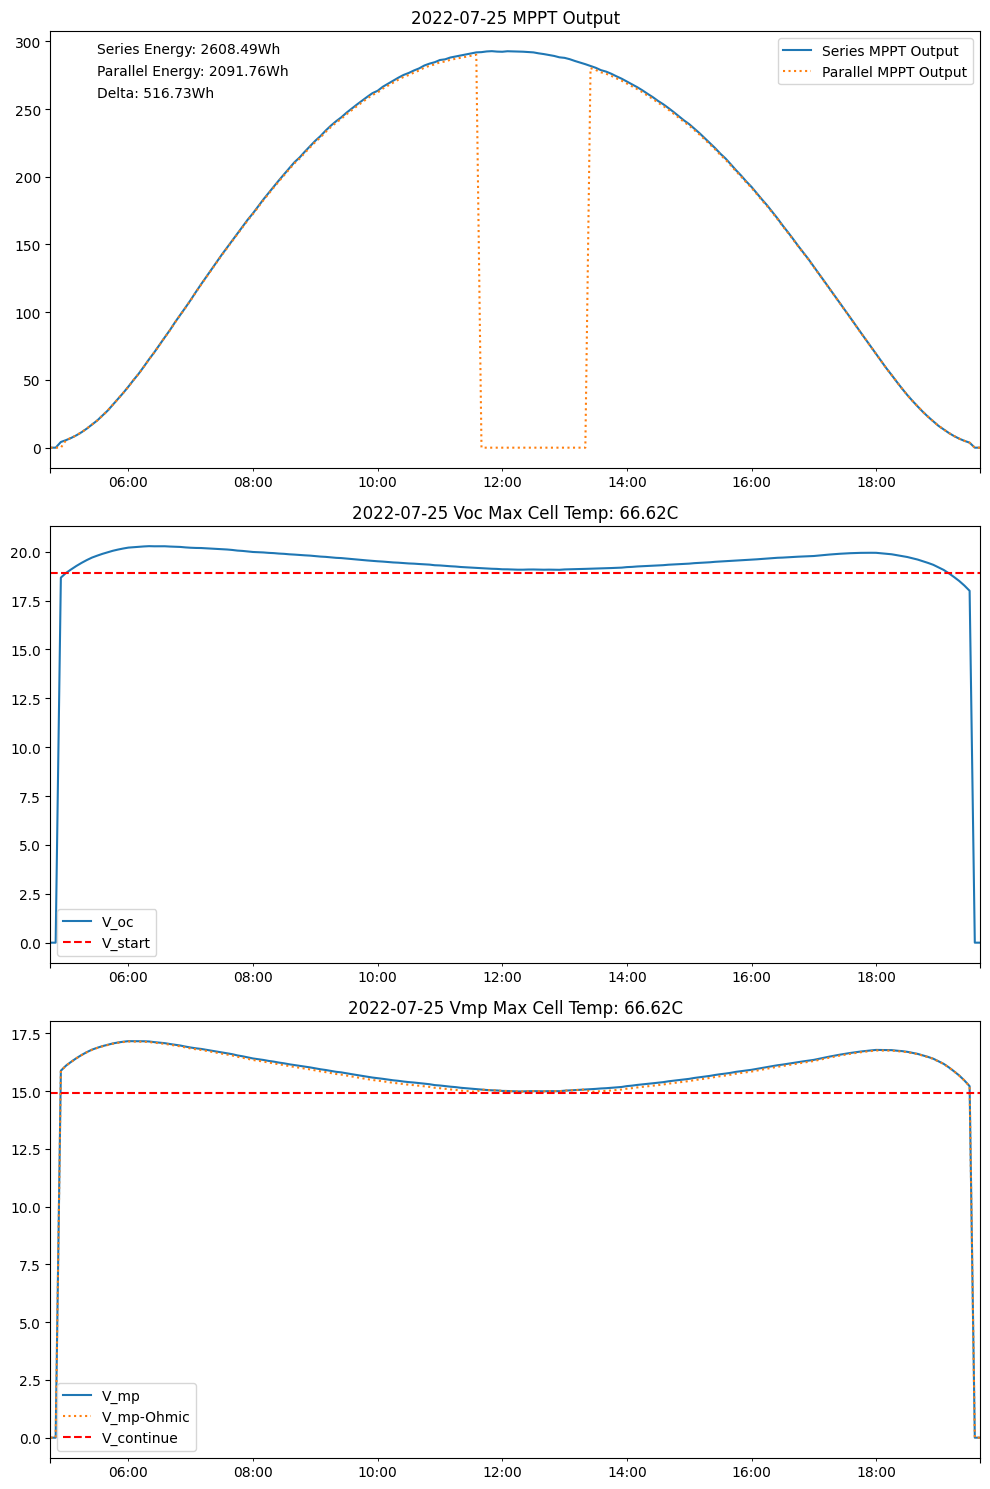

2022-07-26  delta [W-hr]:  975.2752598097325  max cell temp [C]: 68.8605490972204


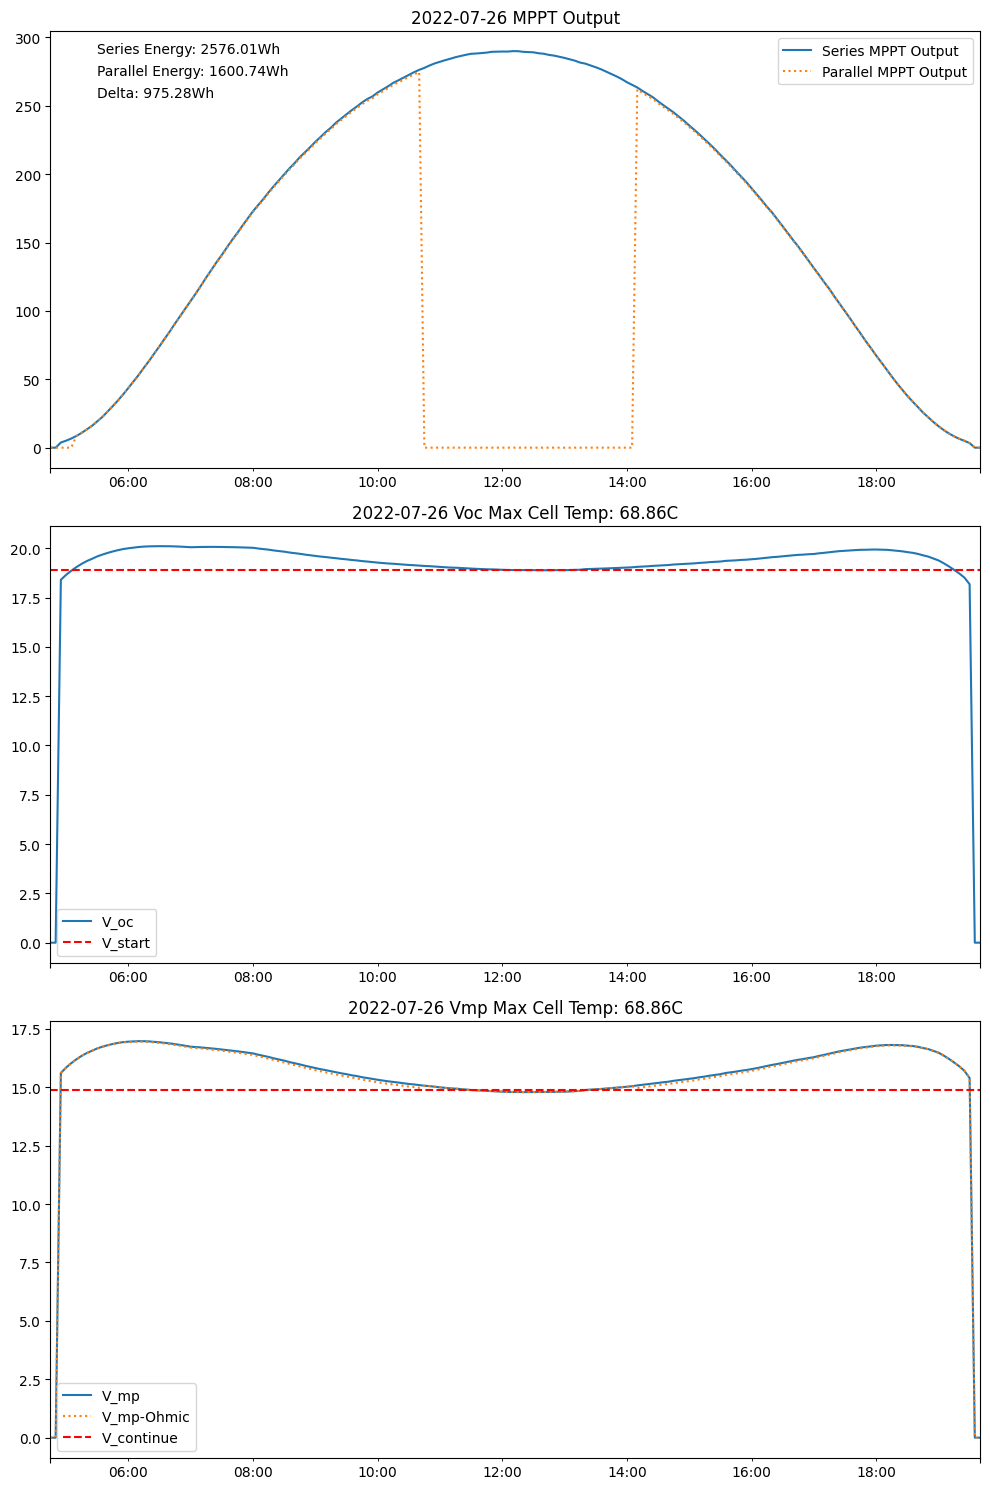

2022-07-27  delta [W-hr]:  443.4673173862311  max cell temp [C]: 66.36719022685604


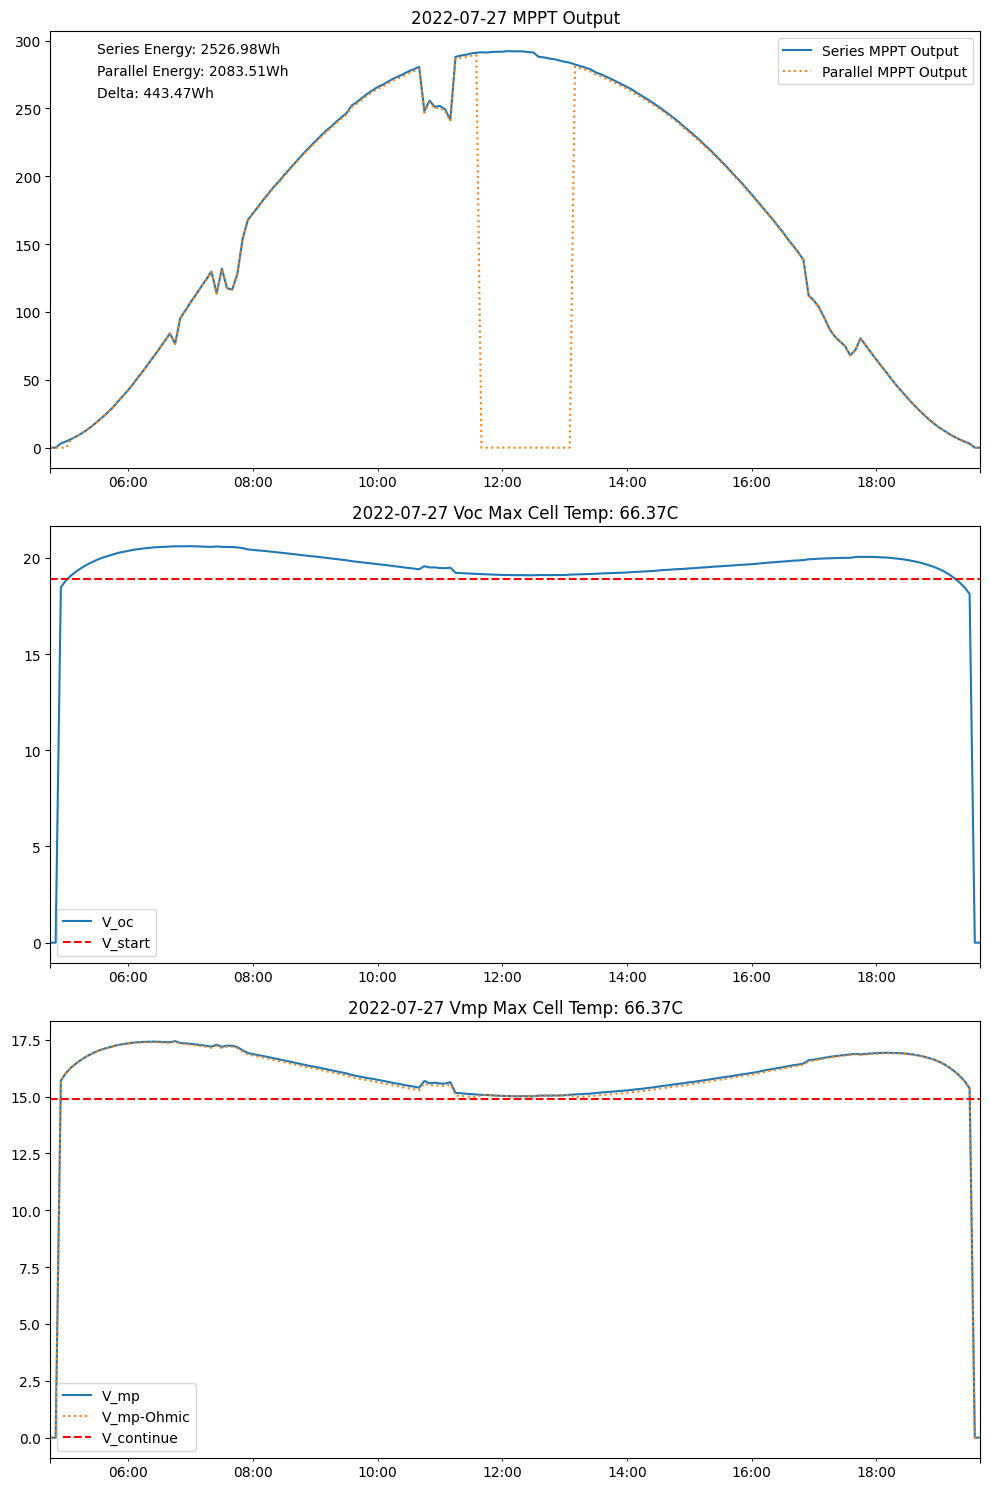

2022-07-28  delta [W-hr]:  827.3744189298561  max cell temp [C]: 69.07466504331747


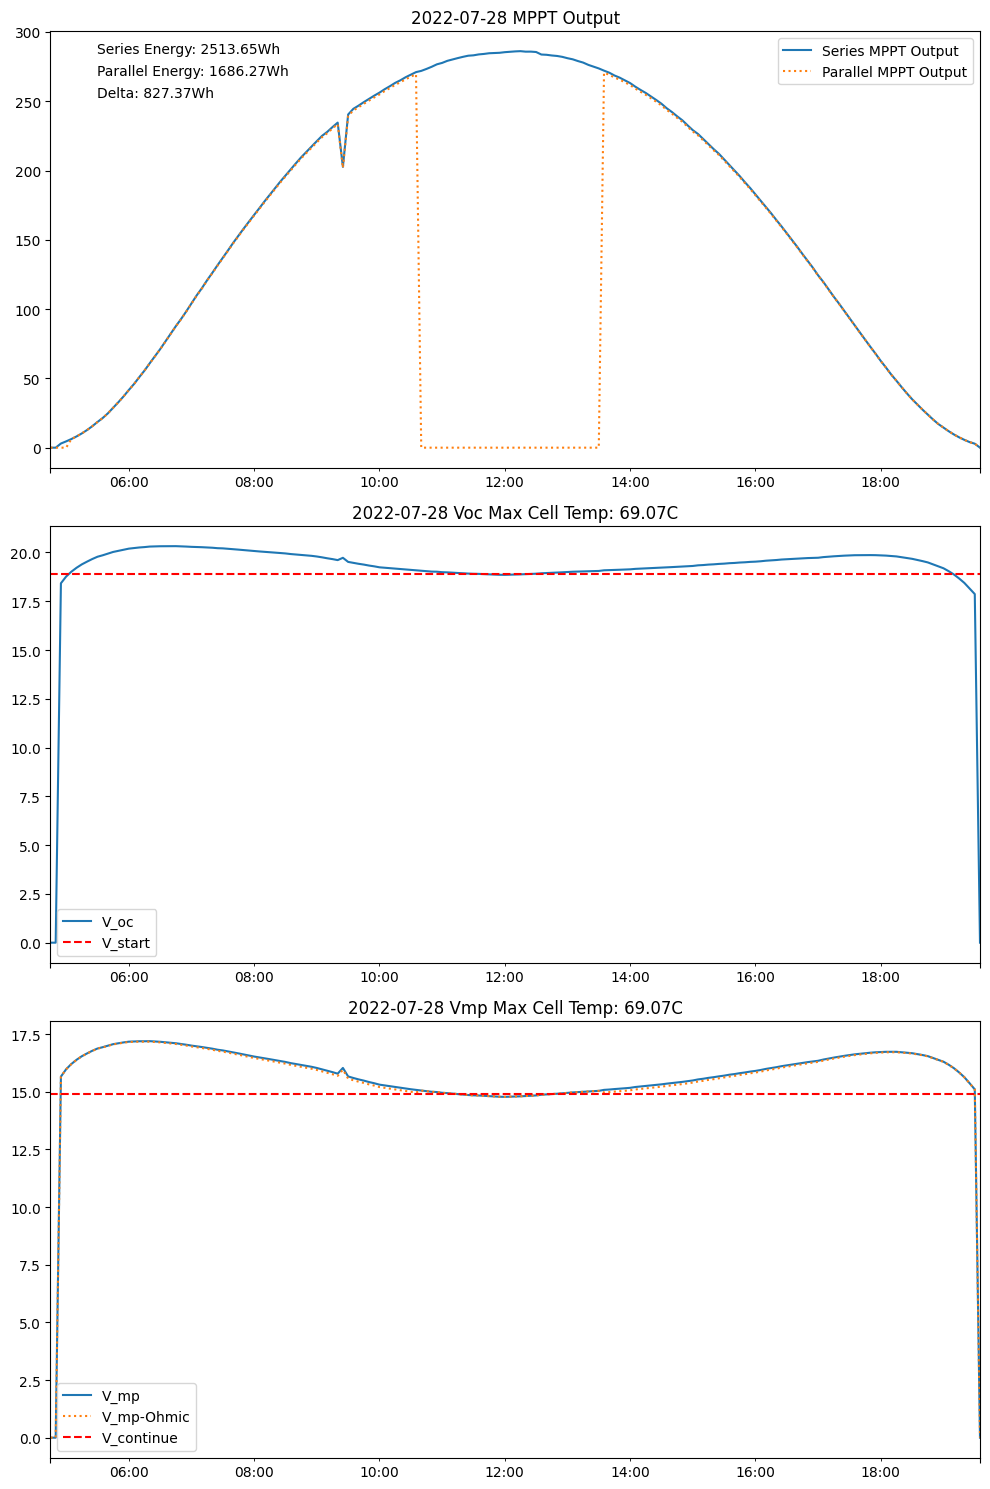

2022-07-29  delta [W-hr]:  821.3623115712087  max cell temp [C]: 67.89998304003734


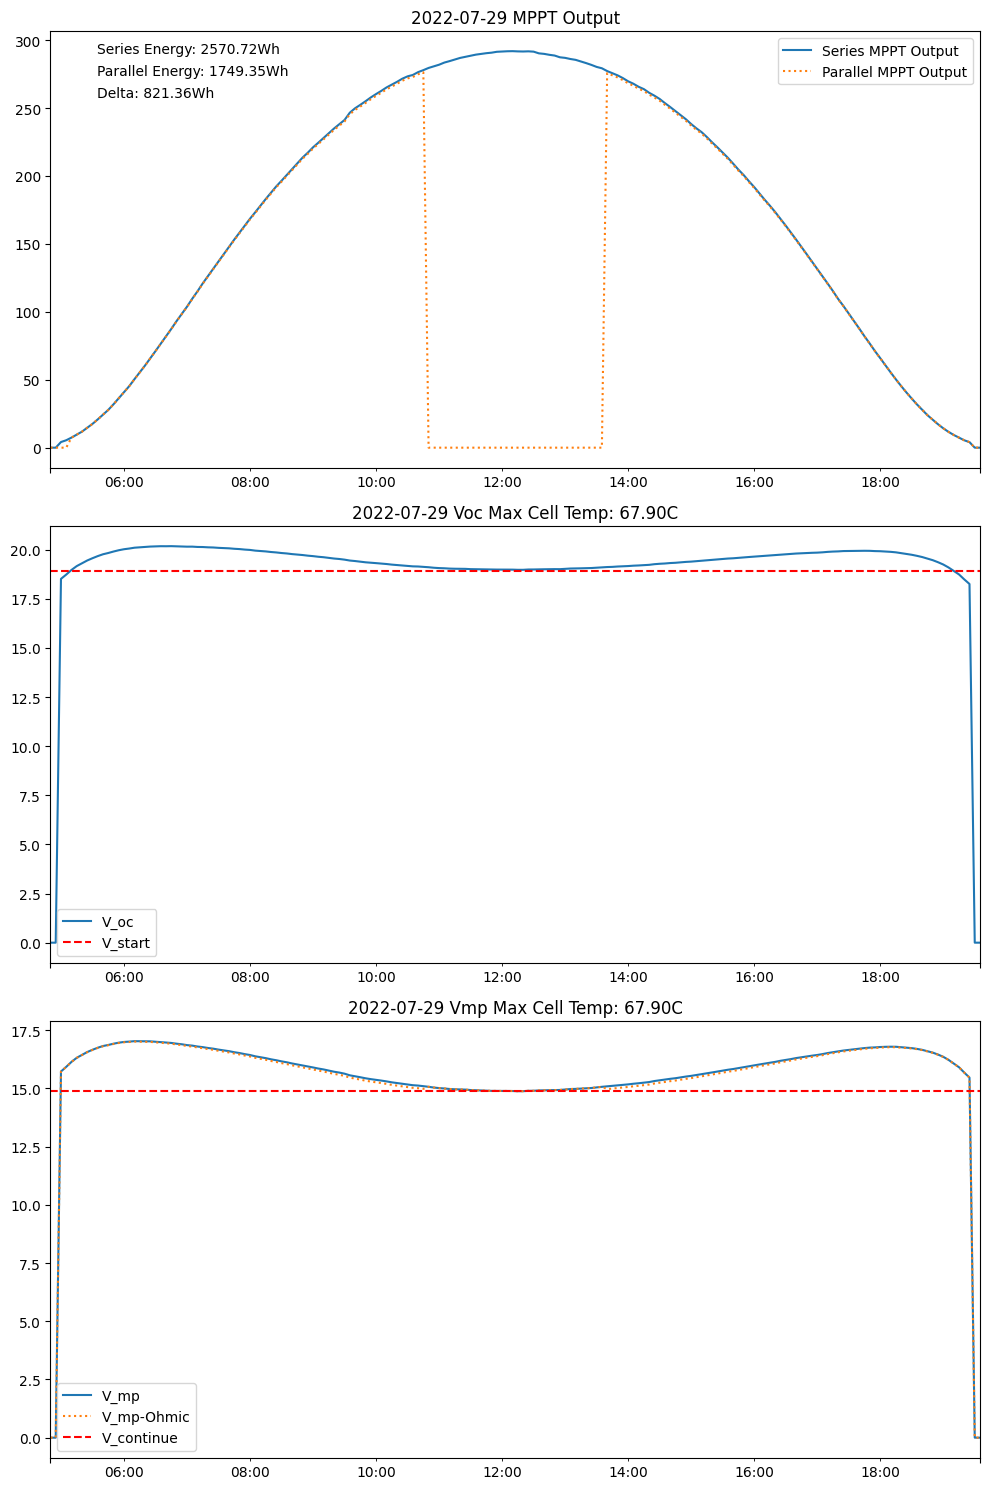

2022-07-30  delta [W-hr]:  429.01395854004  max cell temp [C]: 67.66718299892138


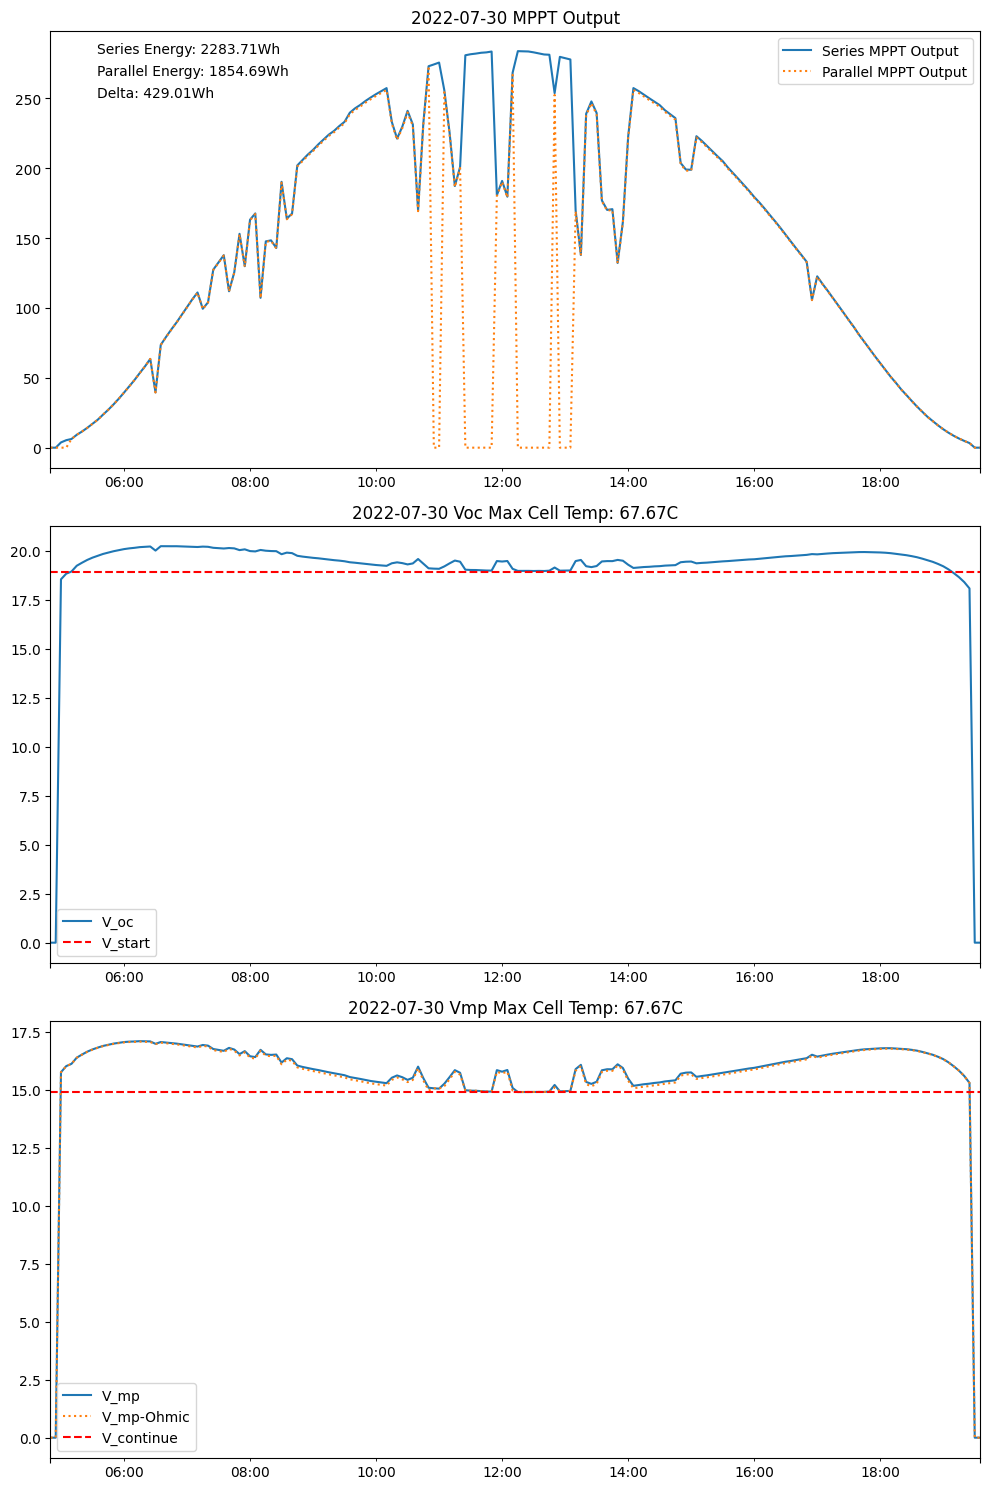

2022-07-31  delta [W-hr]:  9.881740891138634  max cell temp [C]: 63.89318853104613
2022-08-01  delta [W-hr]:  8.68879878796406  max cell temp [C]: 58.15294540831867
2022-08-02  delta [W-hr]:  11.623061738913293  max cell temp [C]: 58.416107553356625
2022-08-03  delta [W-hr]:  11.396490337173873  max cell temp [C]: 58.798771378413434
2022-08-04  delta [W-hr]:  11.357256580827652  max cell temp [C]: 54.69903385626025
2022-08-05  delta [W-hr]:  11.430295471796398  max cell temp [C]: 59.11487725387458
2022-08-06  delta [W-hr]:  11.557951879148732  max cell temp [C]: 61.64164626098025
2022-08-07  delta [W-hr]:  11.110721116577679  max cell temp [C]: 63.46718543881109
2022-08-08  delta [W-hr]:  10.307414424885792  max cell temp [C]: 59.39355194262783
2022-08-09  delta [W-hr]:  3.9214791644835714  max cell temp [C]: 61.41581266538513
2022-08-10  delta [W-hr]:  10.581555881274198  max cell temp [C]: 57.06467864712551
2022-08-11  delta [W-hr]:  10.43367115449746  max cell temp [C]: 60.295873724

In [18]:

# Create a date range for January
#dates = pd.date_range(start='2022-01-01', end='2022-01-31', tz=location.tz)
# Create a date range for July
dates = pd.date_range(start='2022-01-01', end='2022-12-31', tz=location.tz)

# Iterate over the dates
for date in dates:
    # Localize the date to the specified timezone
    
    # Create a DatetimeIndex from the localized_date
    date_index = pd.DatetimeIndex([date])
    
    # Get the sunrise and sunset times for the date
    sun_times = location.get_sun_rise_set_transit(date_index)
    
    # Extract the sunrise and sunset times and convert them to timestamps
    # sunrise = pd.Timestamp(sun_times['sunrise'].values[0], tz=location.tz)
    # sunset = pd.Timestamp(sun_times['sunset'].values[0], tz=location.tz)
    sunrise = sun_times['sunrise'].iloc[0]
    sunset = sun_times['sunset'].iloc[0]
    
    # Slice DataFrames to the range from sunrise to sunset
    weather_slice = weather.loc[sunrise:sunset]
    series_dc_slice = mcSeries.results.dc.loc[sunrise:sunset]
    parallel_dc_slice = mcParallel.results.dc.loc[sunrise:sunset]
    series_ac_slice = mcSeries.results.ac.loc[sunrise:sunset]
    parallel_ac_slice = mcParallel.results.ac.loc[sunrise:sunset]
    parallel_cell_slice = mcParallel.results.cell_temperature.loc[sunrise:sunset]
    parallel_dc_ohmic_slice = mcParallel.results.dc_ohmic_losses.loc[sunrise:sunset]

    # Find the max cell temperature for parallel cases
    # within the slice period
    max_cell_temp = parallel_cell_slice.max()

    # # Create a plot of the column of the sliced psm3_weatherFrames
    # fig, ax = plt.subplots()
    # weather_slice['ghi'].plot(ax=ax, label='ghi')
    # weather_slice['dni'].plot(ax=ax, label='dni')
    # weather_slice['dhi'].plot(ax=ax, label='dhi')
    # # Add a title to the plot
    # ax.set_title(date.strftime('%Y-%m-%d'))
    # # Add a legend to the plot
    # ax.legend()
    # # Show the plot
    # plt.show()

    # Calculate the total energy produced by the series and parallel systems
    series_energy = series_ac_slice.sum() * 5/60
    parallel_energy = parallel_ac_slice.sum() * 5/60
    delta = series_energy - parallel_energy

    print (date.strftime('%Y-%m-%d'),' delta [W-hr]: ', delta, ' max cell temp [C]:' , max_cell_temp)
    if delta/series_energy > 0.01:
        #plot
        # Create a single figure with three subplots in a column
        fig, axs = plt.subplots(3, 1, figsize=(10, 15))

        # Create a plot of the MPPT Output
        series_ac_slice.plot(ax=axs[0], label='Series MPPT Output')
        parallel_ac_slice.plot(ax=axs[0], label='Parallel MPPT Output', linestyle=':')
        axs[0].set_title(date.strftime('%Y-%m-%d')+ ' MPPT Output')
        axs[0].text(0.05, 0.95, f'Series Energy: {series_energy:.2f}Wh', transform=axs[0].transAxes)
        axs[0].text(0.05, 0.90, f'Parallel Energy: {parallel_energy:.2f}Wh', transform=axs[0].transAxes)
        axs[0].text(0.05, 0.85, f'Delta: {delta:.2f}Wh', transform=axs[0].transAxes)
        axs[0].legend()

        # Create a plot of the v_oc for the parallel case
        parallel_dc_slice['v_oc'].plot(ax=axs[1], label='V_oc')
        axs[1].axhline(y=mppt_parameters['v_batt'] + mppt_parameters['v_start_delta'], color='r', linestyle='--', label='V_start')
        axs[1].set_title(date.strftime('%Y-%m-%d')+' Voc'+f' Max Cell Temp: {max_cell_temp:.2f}C')
        axs[1].legend()

        # Create a plot of the v_mp for the parallel case
        parallel_dc_slice['v_mp'].plot(ax=axs[2], label='V_mp')
        (parallel_dc_slice['v_mp']-parallel_dc_ohmic_slice['v_pv_wire_drop']).plot(ax=axs[2], label='V_mp-Ohmic', linestyle=':')
        axs[2].axhline(y=mppt_parameters['v_batt'] + mppt_parameters['v_continue_delta'], color='r', linestyle='--', label='V_continue')
        axs[2].set_title(date.strftime('%Y-%m-%d')+' Vmp'+f' Max Cell Temp: {max_cell_temp:.2f}C')
        axs[2].legend()

        # Adjust the layout of the subplots
        plt.tight_layout()
        plt.show()
